# Facial Landmark Detection - Demonstration
Introduction to Deep Learning - Murphy, Aziha, Alaa

In [2]:
# Before we start let's import the most important libraries
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import cv2 as cv
import keras

# Loading the data

For simplicity we will import already preprocessed data from the [GitHub repo](https://github.com/StrangeGirlMurph/Facial-Landmark-Detection).


In [3]:
import requests
import io

def loadNumpyArrayFromURL(url):
    return np.load(io.BytesIO(requests.get(url).content)).astype(np.float32)

url = lambda x: f"https://github.com/StrangeGirlMurph/Facial-Landmark-Detection/blob/master/data/processedData/{x}.npy?raw=true"

X_train = loadNumpyArrayFromURL(url("X_train"))
y_train = loadNumpyArrayFromURL(url("y_train"))
X_augmented = loadNumpyArrayFromURL(url("X_augmented"))
y_augmented = loadNumpyArrayFromURL(url("y_augmented"))

# The data should include the augmented data.
X = np.concatenate((X_train, X_augmented))
y = np.concatenate((y_train, y_augmented))

The dataset with the augmented data in total consists of 17749 96x96 images and their corresponding labels (15 landmarks with x,y-coordinates each):

In [4]:
X.shape, y.shape

((17749, 96, 96, 1), (17749, 30))

Keep in mind though that this data is already preprocessed and the labels include filling values (-1). The training data now consists of about 50% of augmented data.

# Visualizing the data

Let's look at some images and their landmarks.

In [14]:
label_annotations = ["left eye center","right eye center","left eye inner corner","left eye outer corner", "right eye inner corner", "right eye outer corner", "left eyebrow inner end","left eyebrow outer end","right eyebrow inner end","right eyebrow outer end","nose tip","mouth left corner","mouth right corner","mouth center top lip","mouth center bottom lip"]

def plotImageWithLabels(im, x, y, name):
    labels = np.array(label_annotations)[y != -1]
    
    y = y[y != -1]
    x = x[x != -1]
    
    fig, ax = plt.subplots(facecolor='white')
    fig.set_size_inches(10, 5)
    fig.set_dpi(100) 
    ax.set_title(name)
    ax.set_xlabel("x in px")
    ax.set_ylabel("y in px")

    ax.imshow(im.reshape(96,96), cmap='gray')
    scatter_plot = ax.scatter(x, y, marker="s", s=8, c=range(labels.size), cmap="tab20")
    handles, _ = scatter_plot.legend_elements(num=None)
    ax.legend(handles, labels, title="Facial Landmarks", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

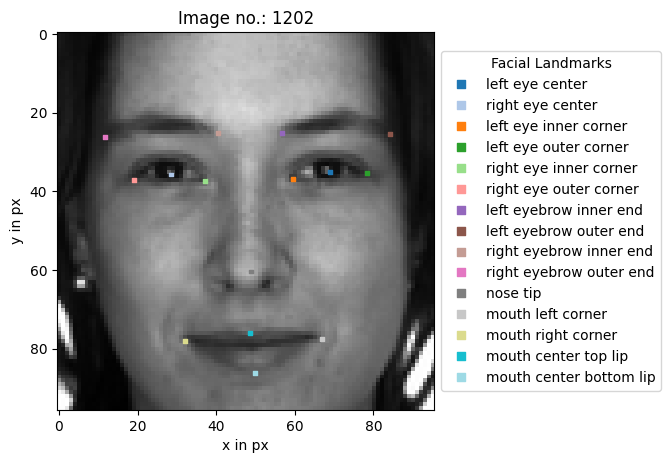

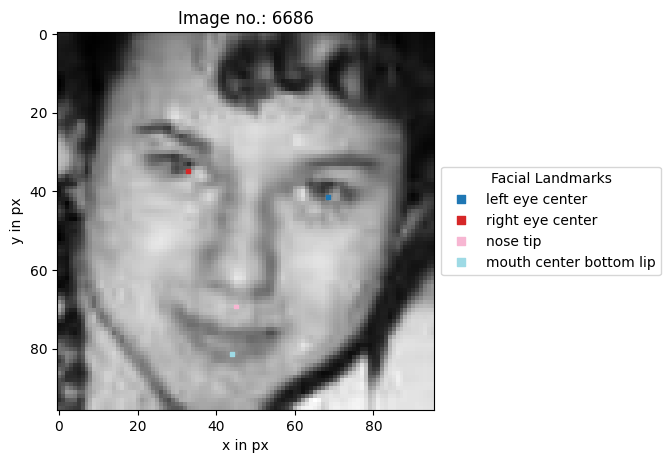

In [15]:
i = 1202
plotImageWithLabels(X[i], y[i][0::2], y[i][1::2], f"Image no.: {i}")
i = 6686
plotImageWithLabels(X[i], y[i][0::2], y[i][1::2], f"Image no.: {i}")

# Loading the trained model

In [ ]:
modelV1 = keras.models.load_model("path to model")
modelV2 = keras.models.load_model("path to model")
modelV3 = keras.models.load_model("path to model")
modelV3.summary()

# Testing the model on labeled data

## Metrics

## Labeled Image

In [ ]:
import matplotlib.pyplot as plt

def testOnDataset(model, data, trueValues=None):
    """Tests the model on the data and shows the result."""
    X, Y = predictOnImages(model, data)
    fig = plt.figure(figsize=(28, 20), dpi=300)

    l = len(data)
    i = 1

    for im, x, y in zip(data, X, Y):
        axis = fig.add_subplot(int(np.ceil(l/5)), 5, i)
        axis.imshow(im, cmap='gray')
        plt.scatter(x, y, c='b', marker='.')
        if trueValues is not None:
            plt.scatter(trueValues[i-1][0::2], trueValues[i-1][1::2], c='r', marker='.')
        i += 1

    plt.tight_layout()
    plt.show()
        
def predictOnImages(model, ims):
    """Predicts on multiple images and returns the list of coordinates of the predicted points."""
    pred = model.predict(ims)
    return ([i[0::2] for i in pred], [i[1::2] for i in pred])



# Testing the model on a webcam input

## Image utility

### Basic image utility

In [ ]:
def mapPointsFromSquareToImage(x, y, c, r, s, w, h):
    """Maps the points to fit image size and returns them. (The prediction points have their origin in the bottom left corner. But opencv uses the top left corner. Plus the function takes care of the scaling and offset.)"""
    return (x*s/96 + c, (y*s/96) + r)


def drawPointsInImage(im, x, y):
    """Plots the points given by the x and y coordinates on the image and returns it."""
    size = min(im.shape[:2])//300
    for i, j in zip(x, y):
        cv.circle(im, (int(i), int(j)), size, (255, 0, 0), -1)
    return im


def prepareImageForPrediction(im):
    """Takes an image and returns it ready for prediction (performs: squaring, converting to grayscale and resizing)."""
    return resizeImageToModelSize(grayImage(squareImage(im))).astype(np.float32)


def grayImage(im):
    """Converts the image to grayscale and returns it."""
    return cv.cvtColor(im, cv.COLOR_BGR2GRAY)


def resizeImageToModelSize(im):
    """Resizes the image to 96x96 and returns it."""
    return cv.resize(im, (96, 96), interpolation=cv.INTER_AREA).reshape(-1, 96, 96, 1)


def mirrorImage(img):
    """Mirrors the image horizontaly and returns it."""
    return cv.flip(img, 1)


def drawSquareInImage(im, x, y, s, rgb=(179, 255, 179), thickness=3):
    """Draws a square in the image with the given coordinates (top left corner), width and height and returns it."""
    cv.rectangle(im, (x, y), (x+s, y+s), rgb, thickness)
    return im

def squareImage(im):
    """Squares the image and returns it. (The size is determind by the minimum of width and height of the input.)"""
    h, w = im.shape[:2]
    ds = min(h, w)//2
    h, w = h//2, w//2   # center
    return im[h-ds:h+ds, w-ds:w+ds]

### Face recognition with the viola jones algorithm

In [ ]:
import os

def violaJonesGetFaceCascade():
    """Returns the face cascade for the Viola Jones algorithm."""
    cv2_base_dir = os.path.dirname(os.path.abspath(cv.__file__))
    return cv.CascadeClassifier(os.path.join(cv2_base_dir, 'data/haarcascade_frontalface_default.xml'))


def violaJones(im, face_cascade, minWandH=1080):
    """Performs Viola Jones detection and returns the bounding boxes of the faces."""
    minSize = 96 * round((minWandH//2)/96)

    faces = face_cascade.detectMultiScale(
        im,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(minSize, minSize),
        flags=cv.CASCADE_SCALE_IMAGE
    )

    return faces

## Video feed